# Flood Impact Mapping with UP42

In the following tutorial we will map the impact of the flooding in urban area using UP42 python SDK and OpenStreetMap data.

This notebook is intended to show how your existing GIS analysis and workflows can seemlessly be integrated with UP42 Python SDK in a few lines of code.

The notebook is divided in following sections:
1. Download Sentinel-2 AOI clipped GeoTiff with [Sentinel-2 L1C MSI AOI clipped data block](https://marketplace.up42.com/block/3a381e6b-acb7-4cec-ae65-50798ce80e64)
2. Calculate Modified Normalized Water Index (MNDWI)
3. Convert MNDWI raster mask to vector mask
4. Extract building footprints polygons from OSM using [UP42 OSM Data Block](https://marketplace.up42.com/block/df2ec03a-50c4-47ac-8a83-2db613869cf9)
5. Plot the impacted buildings with Folium

In [1]:
# imports
import os
from functools import partial

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import rasterio as rio
from rasterio import features
from rasterio.plot import reshape_as_raster, show
from shapely.geometry import LineString, MultiPolygon, Point, Polygon, box
from shapely.geometry import shape as shapely_shp
from shapely.ops import cascaded_union, transform

import folium
import up42

In [2]:
# allows for ignoring errors + division by zero
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Set-up data directory to work with. This is optional though. The SDK creates a directory in the project folder for you!

In [3]:
sentinel_dir = "./results/sentinel/"

## Download data from UP42 platform

In [4]:
# authenticate 
up42.authenticate(cfg_file="flood_config.json")

2020-11-10 16:11:47,283 - Got credentials from config file.
2020-11-10 16:11:47,584 - Authentication with UP42 successful!


In [5]:
project = up42.initialize_project()
    
# init workflow
workflow = project.create_workflow(name="flooding_sentinel")

2020-11-10 16:11:48,164 - Initialized Project(name: sdk-notebook, project_id: 28f674f9-0886-4fab-8774-c9ee4d54eea1, description: , createdAt: 2020-05-11T10:56:58.724Z)
2020-11-10 16:11:48,439 - Created new workflow: ebcf9e58-5ea8-48d9-8103-0e4c999d19ca


Following will fetch the data from UP42 platform corresponding the AOI and parameters we passed into the function.

The area of interest is based on 2019 flooding events in Mid-West, USA in 2019. [Bellevue](https://goo.gl/maps/8UTHGfrLp8KuKk617)

In [6]:
input_tasks = ['sentinelhub-s2-aoiclipped']

# Update workflow object with our desired data block as input_task(s)
workflow.add_workflow_tasks(input_tasks=input_tasks)

# read aoi
aoi = up42.read_vector_file("data/aoi_bellevue_US.geojson", as_dataframe=True)

# construct input parameters
input_parameters = workflow.construct_parameters(geometry=aoi,
                                                geometry_operation="contains",
                                                start_date="2019-03-21",
                                                end_date="2019-03-21", 
                                                limit=1)

# run the actual job
job = workflow.run_job(input_parameters=input_parameters, track_status=True)

2020-11-10 16:11:51,704 - Added tasks to workflow: [{'name': 'sentinelhub-s2-aoiclipped:1', 'parentName': None, 'blockId': '018dfb34-fc19-4334-8125-14fd7535f979'}]
2020-11-10 16:11:52,186 - Selected input_parameters: {'sentinelhub-s2-aoiclipped:1': {'time': '2019-03-21T00:00:00Z/2019-03-21T23:59:59Z', 'limit': 1, 'zoom_level': 14, 'contains': {'type': 'Polygon', 'coordinates': (((-95.929012, 41.114021), (-95.928326, 41.124884), (-95.922832, 41.132642), (-95.906868, 41.123978), (-95.900517, 41.116995), (-95.88747, 41.119452), (-95.878887, 41.119064), (-95.875969, 41.110787), (-95.880947, 41.106519), (-95.901203, 41.102121), (-95.916824, 41.106649), (-95.929012, 41.114021)),)}}}
2020-11-10 16:11:53,679 - Created and running new job: 588e4c36-0cac-4db1-96ed-f0d376947db7.
2020-11-10 16:11:53,959 - Tracking job status continuously, reporting every 30 seconds...
2020-11-10 16:12:20,678 - Job finished successfully! - 588e4c36-0cac-4db1-96ed-f0d376947db7


In [7]:
# download results and quicklooks to results/sentinel/ folder in current directory
job.download_results(sentinel_dir)
job.download_quicklooks(sentinel_dir)

2020-11-10 16:12:25,687 - Downloading results of job 588e4c36-0cac-4db1-96ed-f0d376947db7
2020-11-10 16:12:25,687 - Download directory: results/sentinel
5011it [00:00, 236132.23it/s]
2020-11-10 16:12:26,793 - Download successful of 2 files to output_directory 'results/sentinel': ['data.json', '72b5672d-ceb2-4a00-b7c0-cd736fef022e.tif']
2020-11-10 16:12:27,376 - Download directory: results/sentinel
100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


['results/sentinel/quicklook_72b5672d-ceb2-4a00-b7c0-cd736fef022e.jpg']

You should see a new folder named `result/sentinel/` being created in the current working directory with `.tif` and meatadata file `data.json`. Additionally, we downloaded quicklooks `.jpg` with `job.download_quicklooks()`. This will come handy later while visualising on a folium map.
> **NOTE:** The SDK automatically creates the download directory if not already exists.

In [8]:
# store results and quicklook paths to separate variables
raster_path = [i for i in job.results if i.endswith('.tif')][0]
metadata_path = [i for i in job.results if i.endswith('.json')][0]

In [9]:
# similarly store path for quicklook
ql_path = job.quicklooks[0]

Now, that we have downloaded the necessary data let's move on to the next steps!

In [10]:
raster_path, metadata_path

('results/sentinel/72b5672d-ceb2-4a00-b7c0-cd736fef022e.tif',
 'results/sentinel/data.json')

## Calculate MNDWI

The Modified Normalized Difference Water Index (MNDWI) uses green and SWIR bands for the enhancement of open water features. It also diminishes built-up area features that are often correlated with open water in other indices.

MNDWI = (Green - SWIR) / (Green + SWIR)

- Green = pixel values from the green band
- SWIR = pixel values from the short-wave infrared band

> **Reference**: http://space4water.org/taxonomy/term/1246

In [11]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [12]:
def calc_mndwi(green_band, swir_band):
    mndwi = (green_band - swir_band) / (green_band + swir_band)
    return mndwi.astype(np.float32)

In [13]:
with rio.open(raster_path) as src:
    green = src.read(3)
    swir = src.read(11)

    # normalize band arrays
    green_n = normalize(green)
    swir_n = normalize(swir)

    # get bounds,crs and transform
    src_bounds = src.bounds
    src_crs = src.crs
    src_transform = src.transform

    # compute MNDWI
    mndwi = calc_mndwi(green_band=green_n, swir_band=swir_n)

Let's quickly plot and see how it looks like

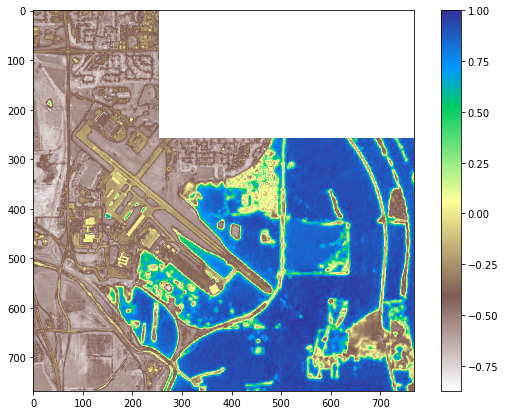

In [14]:
plt.figure(figsize=(10, 7))
plt.imshow(mndwi, cmap='terrain_r')
# Add colorbar to show the index
plt.colorbar();

As we can see the water area is depicted in blue where as land area is brown(-ish) color

## Create Vector Mask

Now that we have computed MNDWI, next step is to isolate boundaries of flooded area from whole image.

This means,
- Apply a deterministic decision boundary / threshold to NDWI values
- Translate the threshold values into boolean value mask (1/0)
- Convert raster into vector boundary (multipolygon)

According the [NDWI-wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_water_index):<br>

> For the second variant of the NDWI, another threshold can also be found in that avoids creating false alarms in urban areas:
> - < 0.3 - Non-water
> - &gt;= 0.3 - Water

Meaning all the values that are `>= 0.3` will be mapped to value `true` and `< 0.3` to `false` respectively.

In [15]:
# create numpy mask
mndwi_msk = (mndwi >= 0.3)

### Pixel to shapely geom

In [16]:
mypoly=[]
for vec, val in features.shapes(source=mndwi_msk.astype(np.float32), transform=src_transform):
    mypoly.append({'geom': shapely_shp(vec), 'value': val})

Now, let's convert this to `GeoDataFrame` as it will be easy to do vector based operations as well as to create viz.

In [17]:
# to gdf
submerged = gpd.GeoDataFrame(mypoly, crs=src_crs, geometry='geom')

In [18]:
# value counts
submerged['value'].value_counts()

1.0    169
0.0    118
Name: value, dtype: int64

We see that `submerged` have two unique values (0.0, 1.0). However, `1.0` corresponds to `water` so it makes sense to filter out land-area from gdf.

In [19]:
# filter by water area
submerged = submerged[submerged['value'] > 0]

In [20]:
# shape should be 203 based on value count cell above
submerged.shape[0]

169

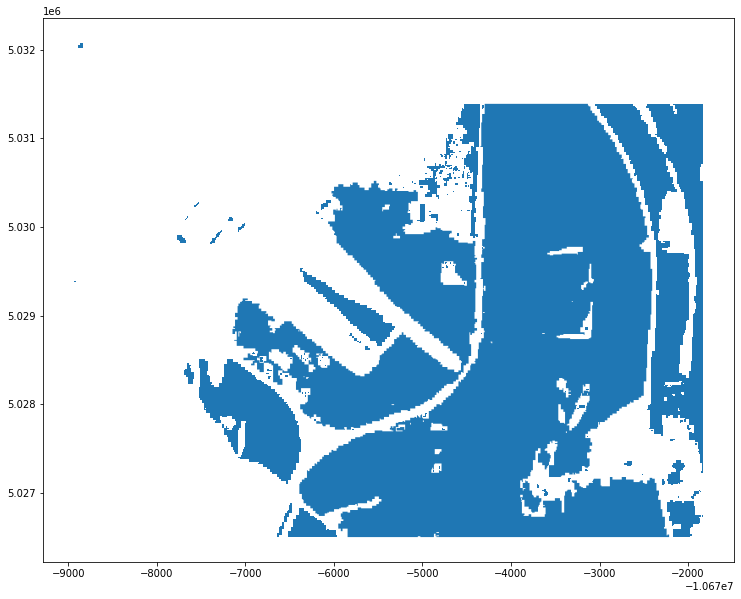

In [21]:
# quick plot
submerged.plot(figsize=(15, 10));

Now that we have vectorized boundaries of flooded area which we will use to intersect with building footprint polygons from OSM. It is better to collapse all individual polygons into a single Multipolygon geometry. <br>
Also, note the x and y axis values!! (**HINT:** crs)

In [22]:
boundary = cascaded_union(list(submerged['geom']))

## Retrieve Building Footprints from OSM

In this section, we will now retrieve building footprints from OpenStreetMap. At UP42, we recently developed an [OpenStreetMap Data Block](https://marketplace.up42.com/block/df2ec03a-50c4-47ac-8a83-2db613869cf9) which is available on our marketplace.

As hinted before, the coordinate system of Sentinel-2 data is in `EPSG:3857` and the OSM query is done in `EPSG:4326`. Therefore, we'll need to perform some coordinate transformation here for both the OSM data retrieval as well as plotting the results with Folium. Let's define the transform.

In [23]:
# transform crs
crs_project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'), # source coordinate system
    pyproj.Proj(init='epsg:4326') # destination coordinate system
)

In [24]:
# read bounds from dataset and transform to wgs84
osm_poly = transform(crs_project, box(*src_bounds))

In the next part, we will create a new workflow within the scope of same project that we initialized and authenticated in earlier part.

In [25]:
workflow_osm = project.create_workflow(name="flooding_osm")

# input task name for the OSM
input_tasks_osm = ['openstreetmap']

# Update workflow object with our desired data block as input_task(s)
workflow_osm.add_workflow_tasks(input_tasks=input_tasks_osm)

# read aoi
aoi = up42.read_vector_file("data/aoi_bellevue_US.geojson", as_dataframe=True)

# construct input parameters
input_parameters = workflow_osm.construct_parameters(geometry=aoi,
                                                    geometry_operation="bbox",
                                                    start_date="2019-03-21",
                                                    end_date="2021-03-21")

2020-11-10 16:12:29,761 - Created new workflow: 6e9f41c2-4590-4789-84cd-b001ccea3c1f
2020-11-10 16:12:32,874 - Added tasks to workflow: [{'name': 'openstreetmap:1', 'parentName': None, 'blockId': 'df2ec03a-50c4-47ac-8a83-2db613869cf9'}]


The job is almost ready to be run. If you notice carefully, the `end_date` parameter is in the future. The block converts the future date to today's date.

We have constructed the `input_parameters` but we haven't yet mentioned that we want to retrieve `building_footprints` from OSM. This block offers all possible combinations of the map features offerred by OSM. Full list can be found [here](https://wiki.openstreetmap.org/wiki/Map_Features). Table below lists some examples of constructing tags.

|OSM feature         |Input Parameter (`osm_tags`) |
|--------------------|-----------------------------|
|Roads               |`highway=*`             |
|Water bodies        |`natural=water`               |
|Building footprints |`building=*`        |
|Land use            |`landuse=*`                   |

Here, the variable `input_parameters` is nothing but a native python `dict`. We can add `osm_tag = ["building=*"]` to this dictionary. The key `osm_tag` can be a list of all above tags as well.

In [26]:
# add osm_tags to input_parameters
input_parameters['openstreetmap:1']["osm_tags"] = ["building=*"]

In [27]:
# run the job
job_osm = workflow_osm.run_job(input_parameters=input_parameters, track_status=True)

2020-11-10 16:12:33,211 - Selected input_parameters: {'openstreetmap:1': {'time': '2019-03-21T00:00:00Z/2021-03-21T23:59:59Z', 'osm_tags': ['building=*'], 'bbox': [-95.929012, 41.102121, -95.875969, 41.132642]}}
2020-11-10 16:12:38,019 - Created and running new job: f5b5a7a3-1e17-4e14-a5b1-1893f3acbef2.
2020-11-10 16:12:38,306 - Tracking job status continuously, reporting every 30 seconds...
2020-11-10 16:12:59,757 - Job finished successfully! - f5b5a7a3-1e17-4e14-a5b1-1893f3acbef2


In [28]:
# define download directory
osm_dir = "./results/osm/"

# download results
job_osm.download_results(osm_dir)

2020-11-10 16:13:04,769 - Downloading results of job f5b5a7a3-1e17-4e14-a5b1-1893f3acbef2
2020-11-10 16:13:04,770 - Download directory: results/osm
26it [00:00, 39945.75it/s]
2020-11-10 16:13:05,333 - Download successful of 2 files to output_directory 'results/osm': ['data.json', 'building=*_2020-11-10T15_11_02Z.geojson']


['results/osm/data.json',
 'results/osm/a7a94c20-586e-4447-9369-e7e95ed87b77/building=*_2020-11-10T15_11_02Z.geojson']

In [29]:
building_footprints_path = [i for i in job_osm.results if "building=*" in i][0]
building_footprints_path

'results/osm/a7a94c20-586e-4447-9369-e7e95ed87b77/building=*_2020-11-10T15_11_02Z.geojson'

In [30]:
gdf = gpd.read_file(building_footprints_path)

# reproject to EPSG:3857
gdf_proj = gdf.to_crs(src_crs)

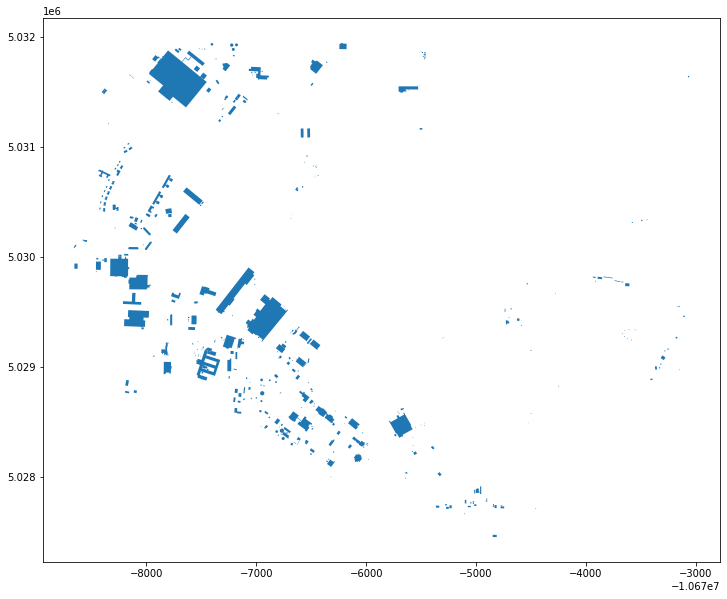

In [31]:
gdf_proj.plot(figsize=(15, 10));

Notice that the coordinates, here, are in (lat, lon). Now, that data is extracted, we can transform it to the crs of the dataset.

Doing this right now prevents any inconsistencies (with plotting, intersecting etc.) at later point as well as ensures sanity!!

In [32]:
gdf_proj.head(1)

,type,id,tags,geometry
0,way,32811010,"{'building': 'hangar', 'layer': '1'}","POLYGON ((-10675793.142 5028506.241, -10675786..."


## Extract Flood Impacted buildings

Until this point, we set the stage for actual task. Basically, the building footprints that intersects the Multipolygon (one we created from MNDWI) are effected building and those that are not are not-effected buildings!

In [33]:
effected = gdf_proj[gdf_proj['geometry'].intersects(boundary)]
# change coordinate system for plotting
effected.to_crs(crs='EPSG:4326', inplace=True)

/Users/prayag.thakkar/Envs/up42-py-dev/lib/python3.7/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [34]:
not_effected = gdf_proj[~gdf_proj['geometry'].intersects(boundary)]
# change coordinate system for plotting
not_effected.to_crs(crs='EPSG:4326', inplace=True)

/Users/prayag.thakkar/Envs/up42-py-dev/lib/python3.7/site-packages/geopandas/geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


In [35]:
# quick sanity check
gdf_proj.shape[0] == (effected.shape[0] + not_effected.shape[0])

True

It's time for plotting. We will use Folium library for displaying our results. Of course, it requires a bit of massaging before we get to the plotting

### Plotting

In [36]:
# bbox centroid serves as the center point for the folium map
bbox_centroid = list((osm_poly.centroid).coords[:][0])
bbox_centroid = [bbox_centroid[-1], bbox_centroid[0]]
bbox_centroid

[41.12074089370247, -95.899658203125]

In [37]:
# extracts bounds for image overlay
lon_min, lat_min, lon_max, lat_max = osm_poly.bounds

In [38]:
style1 = {'fillColor': '#228B22', 'color': 'red'}
style2 = {'fillColor': '#00FFFFFF', 'color': '#00FFFFFF'}

In [39]:
# init folium map
m = folium.Map(bbox_centroid, zoom_start=15)

# add effected buildings
folium.GeoJson(effected.to_json(), style_function=lambda x:style1).add_to(m);

# add not_effected buildings
folium.GeoJson(not_effected.to_json(), style_function=lambda x:style2).add_to(m);

# add raster png quicklook
folium.raster_layers.ImageOverlay(image=ql_path, bounds=[[lat_min, lon_min], [lat_max, lon_max]], opacity=0.8).add_to(m);

In [40]:
folium.LayerControl().add_to(m)
m

As we can see the buildings impacted by flooding in red and those that are not impacted are in blue.

It should be noted that success of the analysis depends on the availability of the data in OSM!!

In [41]:
m.save("/Users/prayag.thakkar/Desktop/folium_map.html")